Train Using Resnet Instead of VGG


 Summary of Results:
LINEAR:
  Validation Accuracy: 0.8247
  Test Accuracy:       0.8418
  Best Parameters:     {'svm__C': 1}


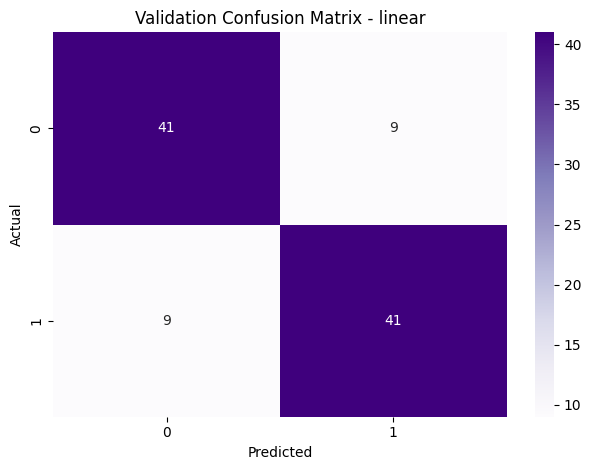

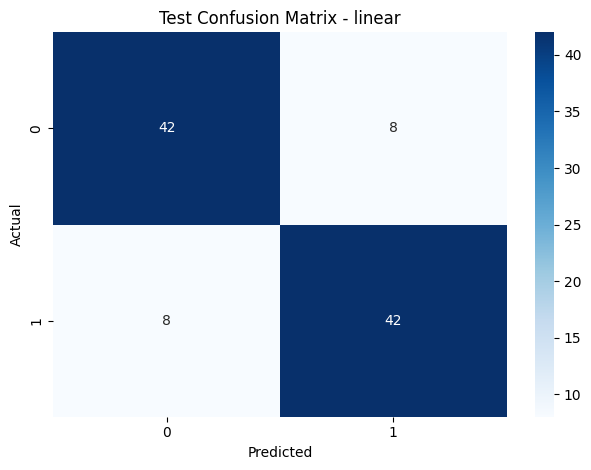

POLY:
  Validation Accuracy: 0.8475
  Test Accuracy:       0.8476
  Best Parameters:     {'svm__C': 10, 'svm__degree': 3, 'svm__gamma': 'scale'}


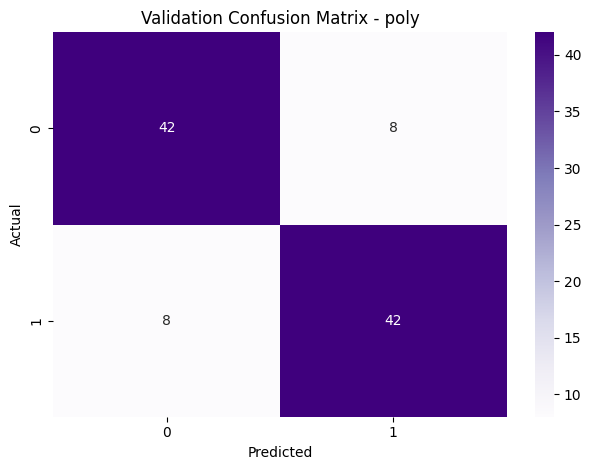

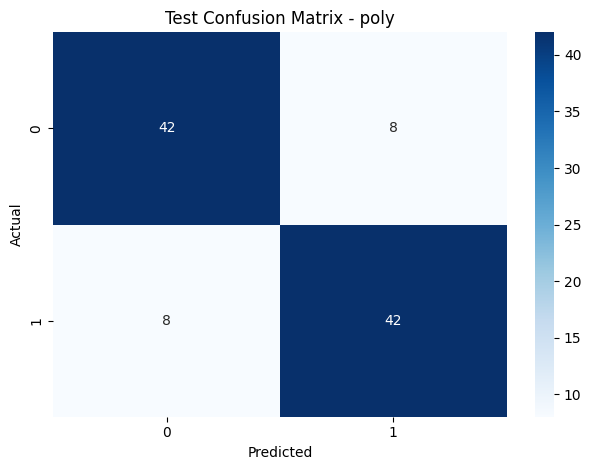

RBF:
  Validation Accuracy: 0.8200
  Test Accuracy:       0.8390
  Best Parameters:     {'svm__C': 1, 'svm__gamma': 'auto'}


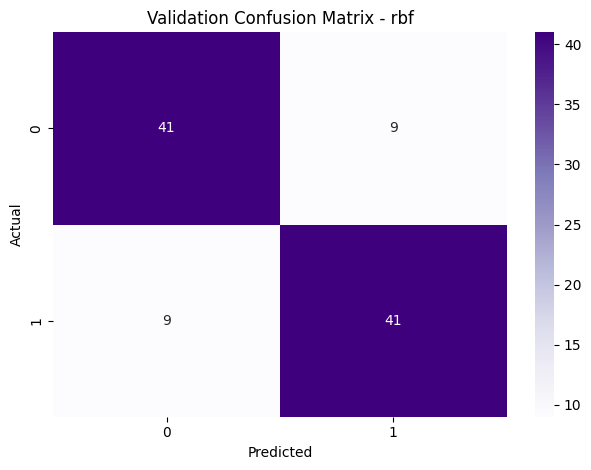

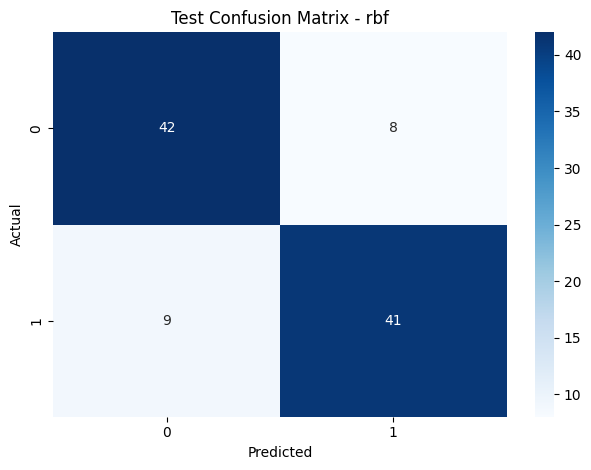

SIGMOID:
  Validation Accuracy: 0.8076
  Test Accuracy:       0.8158
  Best Parameters:     {'svm__C': 0.1, 'svm__gamma': 'scale'}


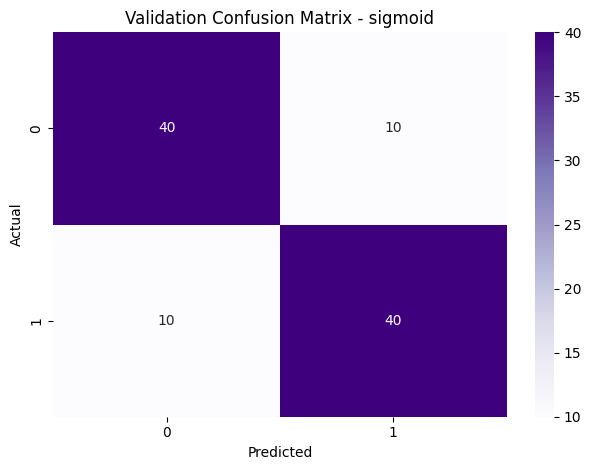

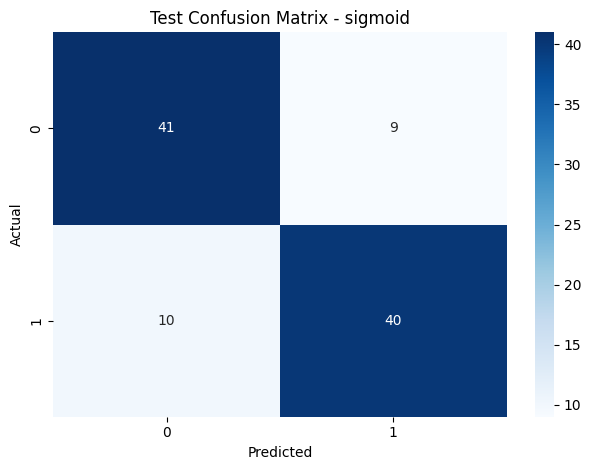

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Constants ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = "dataset"
RANDOM_STATE = 42
PCA_COMPONENTS = 1300

# === Step 1: Load Image Data ===
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def load_data(split):
    return datagen.flow_from_directory(
        os.path.join(DATASET_PATH, split),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

print("📦 Loading data...")
train_gen = load_data("train")
val_gen = load_data("validation")
test_gen = load_data("test")

# === Step 2: Feature Extraction via ResNet50 ===
print(" Extracting ResNet50 features...")
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet.trainable = False

def extract_features(generator):
    features = resnet.predict(generator, verbose=1)
    return features.reshape(features.shape[0], -1), generator.classes

X_train, y_train = extract_features(train_gen)
X_val, y_val = extract_features(val_gen)
X_test, y_test = extract_features(test_gen)

X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

# === Step 3: PCA ===
print(" Applying PCA...")
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# PCA Variance Plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axvline(PCA_COMPONENTS, color='red', linestyle='--', label=f"{PCA_COMPONENTS} components")
plt.title("Cumulative PCA Explained Variance")
plt.xlabel("Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Step 4: Grid Search for All Kernels (not just best) ===
print(" Grid Searching all SVM kernels...")

results = {}

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    print(f"\n Kernel = {kernel}")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=kernel, class_weight='balanced', random_state=RANDOM_STATE))
    ])

    param_grid = {
        'svm__C': [0.1, 1, 10],
    }
    if kernel == 'poly':
        param_grid['svm__degree'] = [2, 3]
    if kernel in ['rbf', 'poly', 'sigmoid']:
        param_grid['svm__gamma'] = ['scale', 'auto']

    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
    grid.fit(X_train_pca, y_train)

    print(" Best Parameters:", grid.best_params_)
    best_model = grid.best_estimator_

    # === Validation Evaluation ===
    y_val_pred = best_model.predict(X_val_pca)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f" Validation Accuracy ({kernel}): {val_acc:.4f}")
    print(classification_report(y_val, y_val_pred))
    sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Purples')
    plt.title(f"Validation Confusion Matrix - {kernel}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # === Test Evaluation ===
    y_test_pred = best_model.predict(X_test_pca)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"🧪 Test Accuracy ({kernel}): {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Test Confusion Matrix - {kernel}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Store results
    results[kernel] = {
        'val_acc': val_acc,
        'test_acc': test_acc,
        'params': grid.best_params_
    }

# Summary Table
print("\n Summary of Results:")
for kernel, metrics in results.items():
    print(f"{kernel.upper()}: Val Acc = {metrics['val_acc']:.4f}, Test Acc = {metrics['test_acc']:.4f}, Params = {metrics['params']}")